Uniform in x, y - mixture of sech^2 in z


In [12]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
import corner
from tqdm.auto import tqdm, trange

from solaroid.coordinates import gal_to_schmagal, schmagal_to_gal
from solaroid.simulate import invt_sample_z
from solaroid.likelihood import (
    ln_density, ln_integrand, get_ln_Veff, ln_likelihood)
from solaroid.stats import ln_normal, ln_two_sech2

In [2]:
max_dist = 1.5 * u.kpc
min_b = 30 * u.deg

def S(b, d):
    sim_mask = (
        (np.abs(b) > min_b) &
        (d < max_dist)
    )
    return sim_mask

In [3]:
usys = [u.pc, u.rad, u.Msun, u.Myr]

zgrid = np.linspace(-5e3, 5e3, 1024)
rho = np.exp(ln_two_sech2(zgrid, h1=200., h2=800., f=0.3))

Text(0.5, 0, '$z$ [pc]')

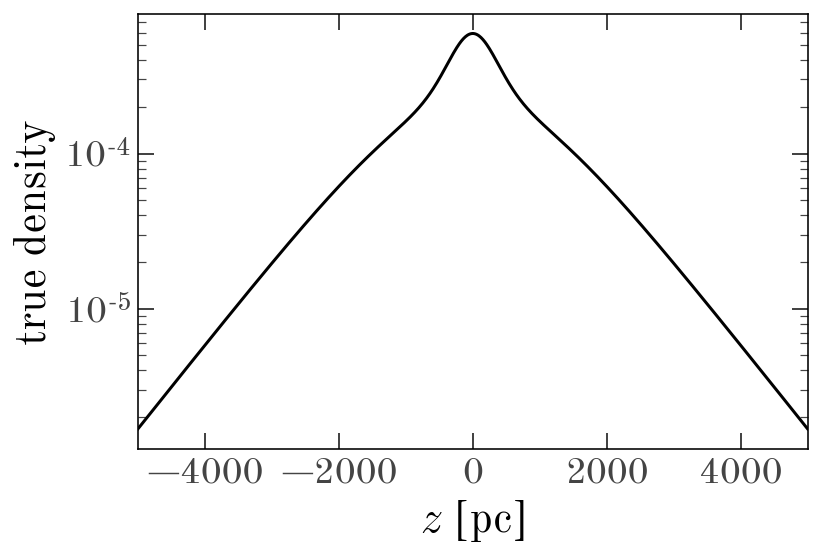

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(zgrid, rho, marker='')
plt.xlim(zgrid.min(), zgrid.max())
plt.yscale('log')
plt.ylabel('true density')
plt.xlabel('$z$ [pc]')

In [5]:
truth = {
    'h1': 200 * u.pc,
    'h2': 800 * u.pc,
    'f': 0.3,
    'x_sigma': 0.5 * u.kpc,
    'y_sigma': 0.5 * u.kpc,
}
true_args = list(truth.values())

In [24]:
np.mean(z_samples)

<Quantity 1.06891452 pc>

In [28]:
N = 100_000
rng = np.random.default_rng(seed=42)

args = (truth['h1'].value, truth['h2'].value, truth['f'])
z_samples = invt_sample_z(
    ln_two_sech2,
    args=args, 
    size=N,
    rng=rng,
    grid_size=4096
) * u.pc
assert np.mean(z_samples) < 2 * u.pc

# x_samples = rng.uniform(-1, 1, size=N) * u.kpc
# y_samples = rng.uniform(-1, 1, size=N) * u.kpc
x_samples = rng.normal(0, truth['x_sigma'].value, size=N) * truth['x_sigma'].unit
y_samples = rng.normal(0, truth['y_sigma'].value, size=N) * truth['y_sigma'].unit
xyz_samples = np.stack((x_samples, y_samples, z_samples), axis=0)

(0.0001, 0.001)

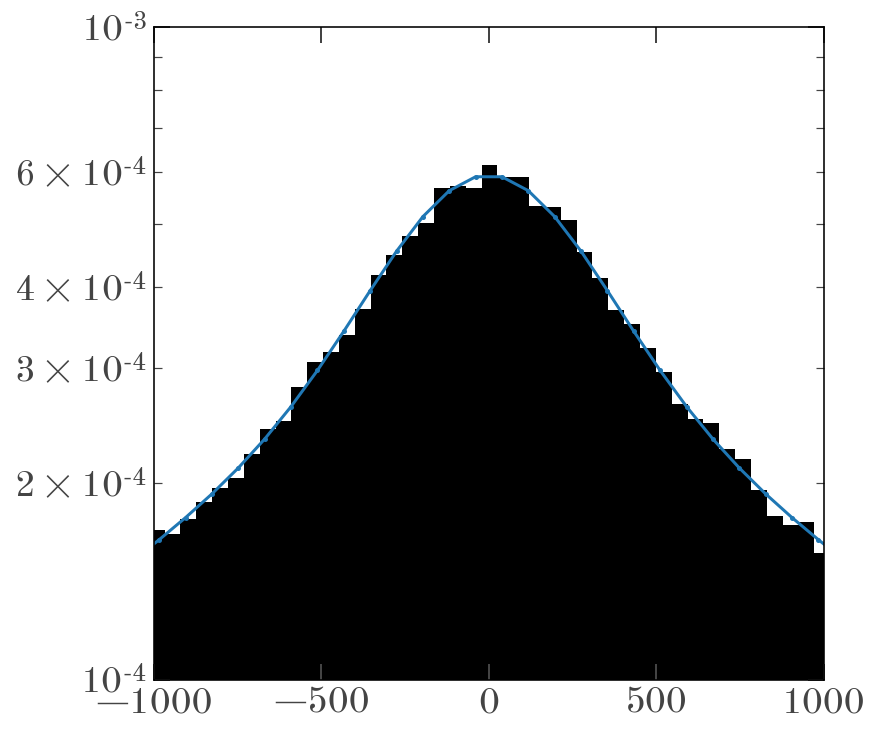

In [33]:
plt.figure(figsize=(6, 6))
plt.hist(z_samples.value, bins=211, density=True);

_zgrid = np.linspace(-5000, 5000, 128)
shit = ln_two_sech2(_zgrid, truth['h1'].value, truth['h2'].value, truth['f'])

plt.plot(_zgrid, np.exp(shit))
plt.yscale('log')
plt.xlim(-1000, 1000)
plt.ylim(1e-4, 1e-3)

In [34]:
truth['zsun'] = 174.35 * u.pc
truth['roll'] = 15.3 * u.deg
# truth['sgrA'] = coord.SphericalRepresentation(0.528 * u.deg, -0.17*u.deg, 8.1 * u.kpc)
truth['sgrA'] = coord.SphericalRepresentation(15.28 * u.deg, -7.4*u.deg, 8.1 * u.kpc)

sim_schmagal = coord.CartesianRepresentation(xyz_samples)

sim_gal = coord.CartesianRepresentation(
    schmagal_to_gal(xyz_samples, 
                    truth['sgrA'], truth['zsun'], truth['roll'])
)
sim_gal_sph = sim_gal.represent_as(coord.SphericalRepresentation)

In [35]:
sim_mask = S(sim_gal_sph.lat, sim_gal_sph.distance)
sim_mask.sum(), len(sim_mask)

(43381, 100000)

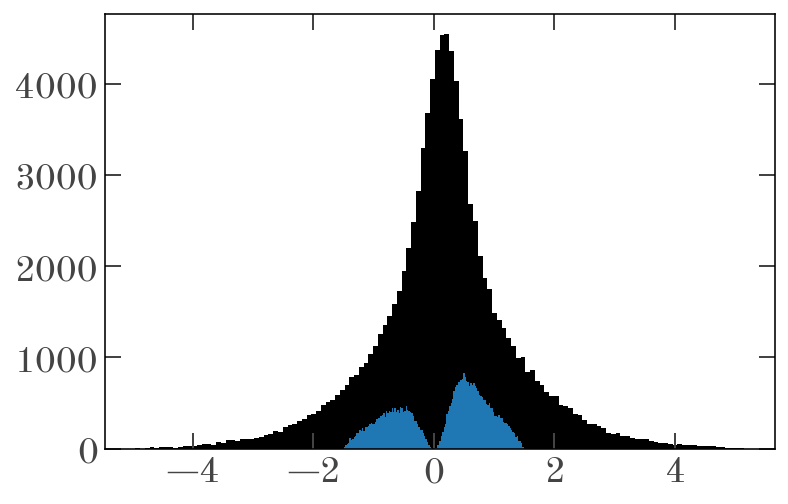

In [36]:
plt.hist(sim_gal.z.value, bins=128);
plt.hist(sim_gal.z.value[sim_mask], bins=128);

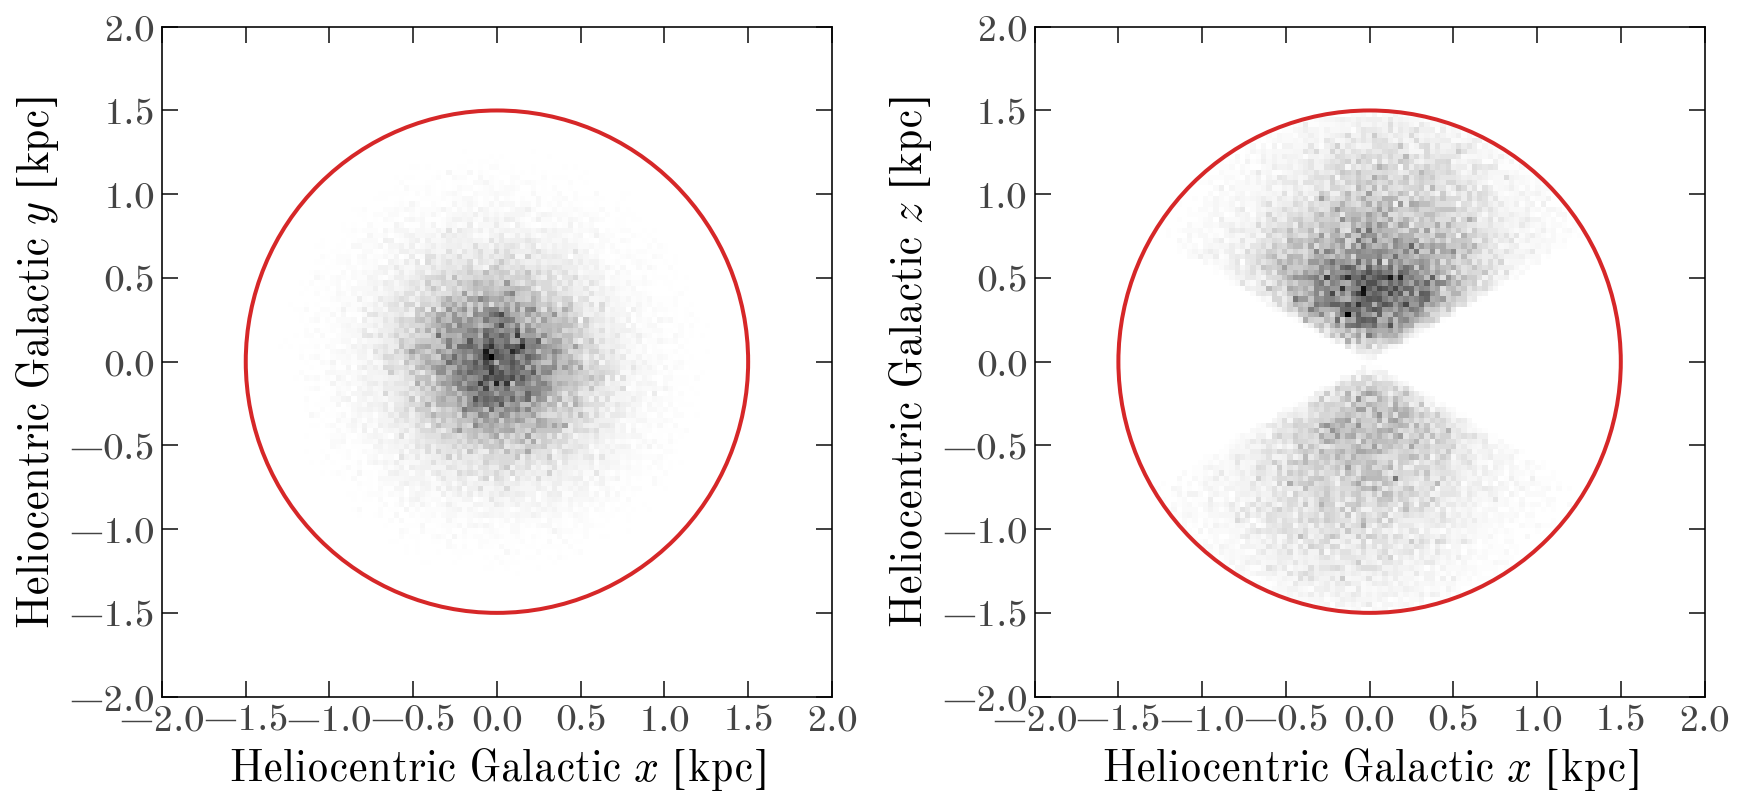

In [37]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(sim_gal.x[sim_mask].value, 
                                sim_gal.y[sim_mask].value), 
                               (sim_gal.x[sim_mask].value, 
                                sim_gal.z[sim_mask].value)], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=max_dist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

In [38]:
x_args = (0., truth['x_sigma'].to_value(u.pc))
y_args = (0., truth['y_sigma'].to_value(u.pc))
z_args = (truth['h1'].value, truth['h2'].value, truth['f'])
gal_args = (truth['sgrA'], truth['zsun'], truth['roll'])

ln_density_args = (
    ln_normal, x_args,
    ln_normal, y_args,
    ln_two_sech2, z_args,
)

ln_integrand(
    0.,
    (31*u.deg).decompose(usys).value,
    (100*u.pc).decompose(usys).value,
    ln_density_args,
    gal_args
)

-12.700532208593428

In [39]:
get_ln_Veff(ln_density_args, gal_args, min_b, max_dist)

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:51: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-0.8405257246678555

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:51: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-547307.1592085477

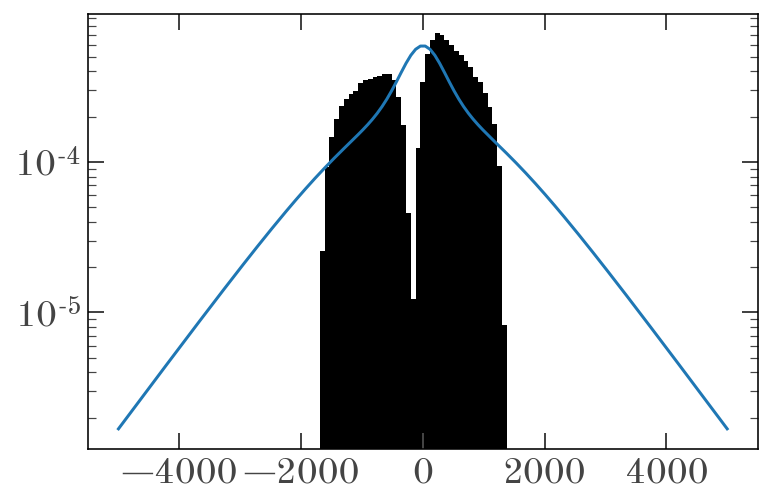

In [40]:
p0 = (
    np.log(sim_gal.shape[0]),
    np.log(truth['h1'].decompose(usys).value),
    np.log(truth['h2'].decompose(usys).value),
    truth['f'],
    truth['zsun'].decompose(usys).value,
    truth['roll'].decompose(usys).value
)
p0_names = (
    'lnn0',
    'lnh1',
    'lnh2',
    'f',
    'zsun',
    'roll'
)
data = sim_gal.xyz.decompose(usys).value[:, sim_mask]
# data = sim_gal.xyz.decompose(usys).value
ln_likelihood(p0, data, truth['sgrA'], ln_density_args, min_b, max_dist,
              plot=True)

In [41]:
sgrA = truth['sgrA']

all_vals = np.linspace(0.9, 1.1, 16)[None] * np.array(p0)[:, None]

all_lls = []
for i in range(len(p0)):
    print(i)
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for j, val in enumerate(vals):
        print(f"{j}/{len(vals)}", end="\r")
        this_p0[i] = val
        lls.append(ln_likelihood(this_p0, data, 
                                 sgrA, ln_density_args, min_b, max_dist))
    all_lls.append(lls)
all_lls = np.array(all_lls)

0
15/16
25/16
35/16
45/16
55/16


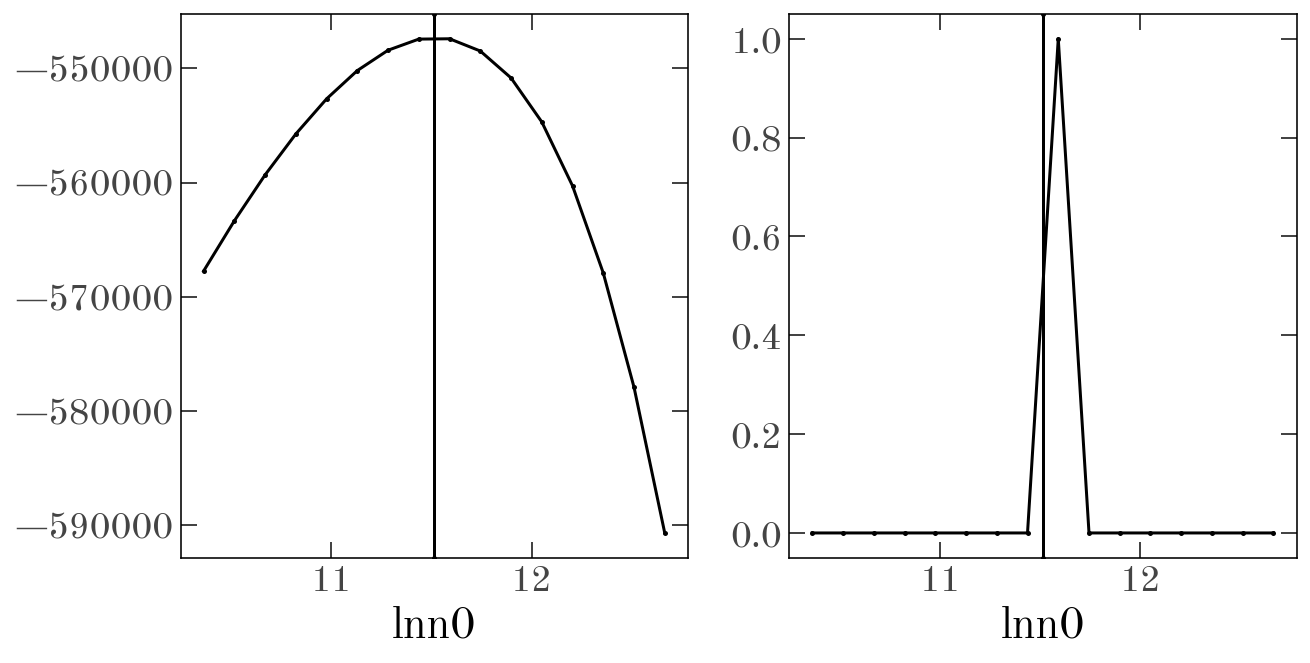

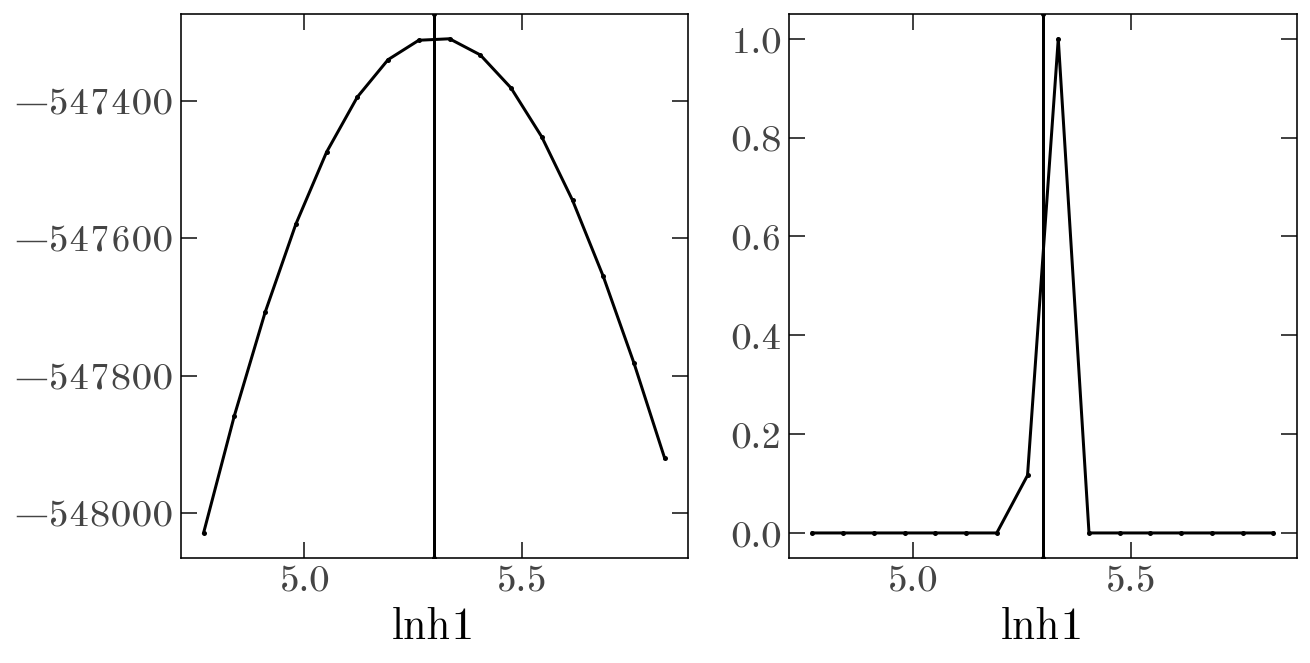

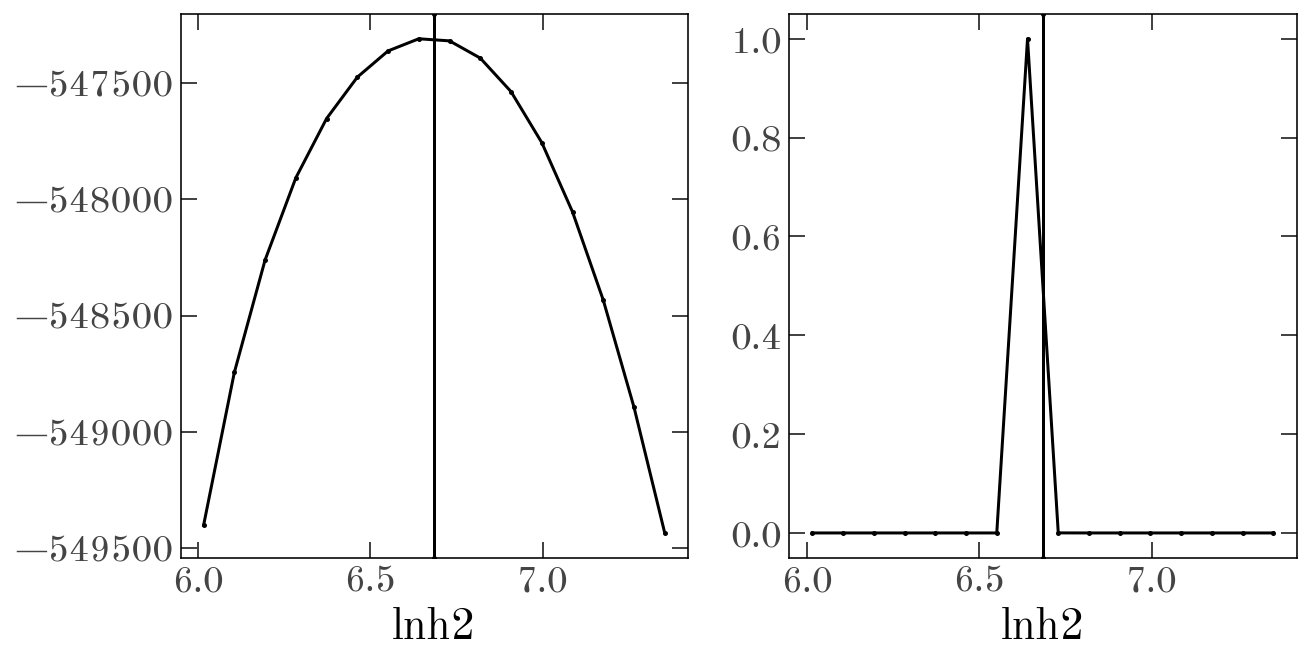

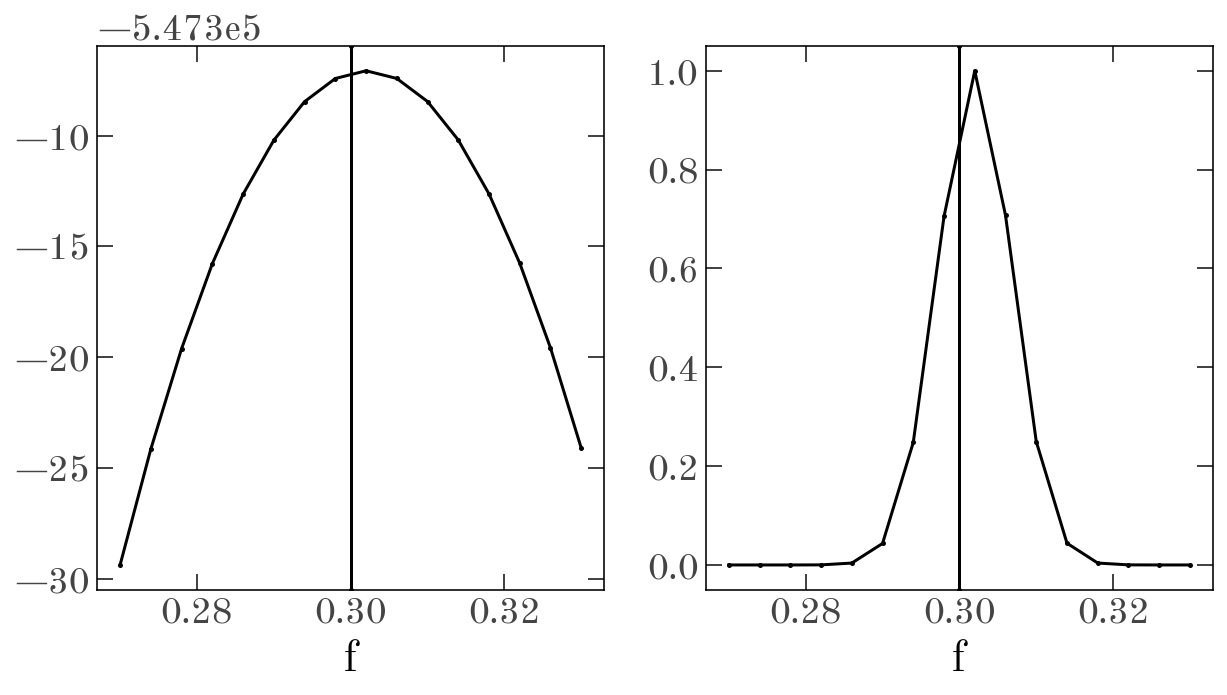

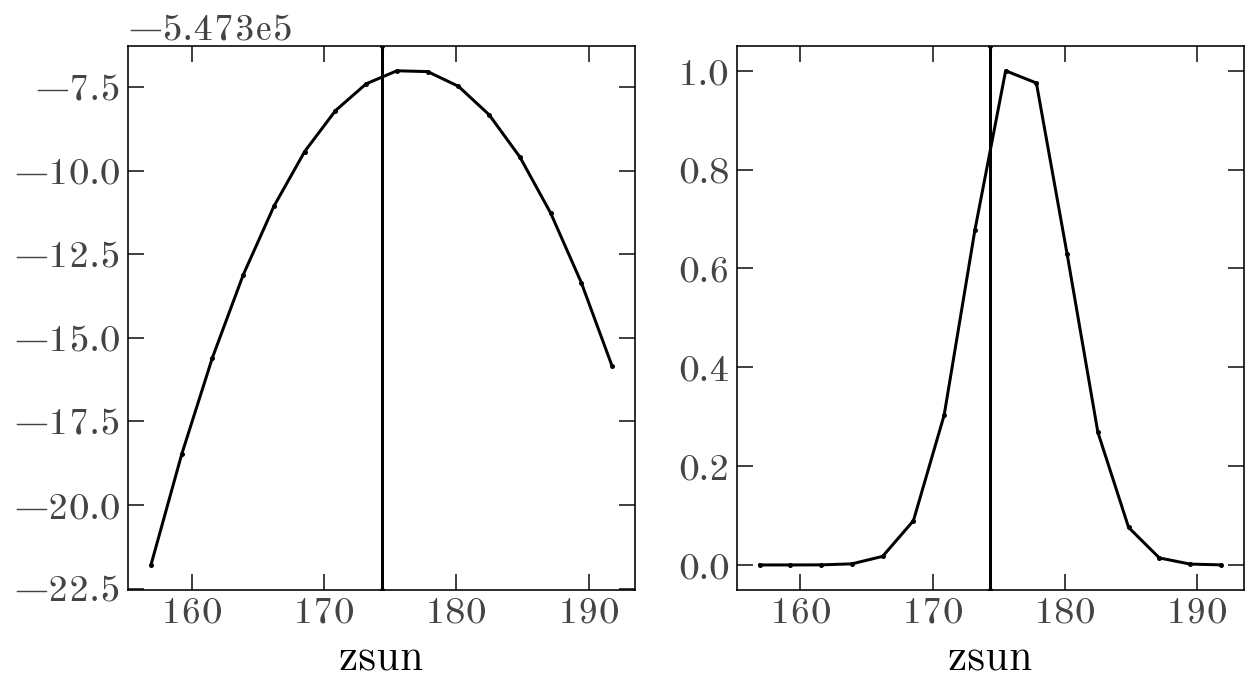

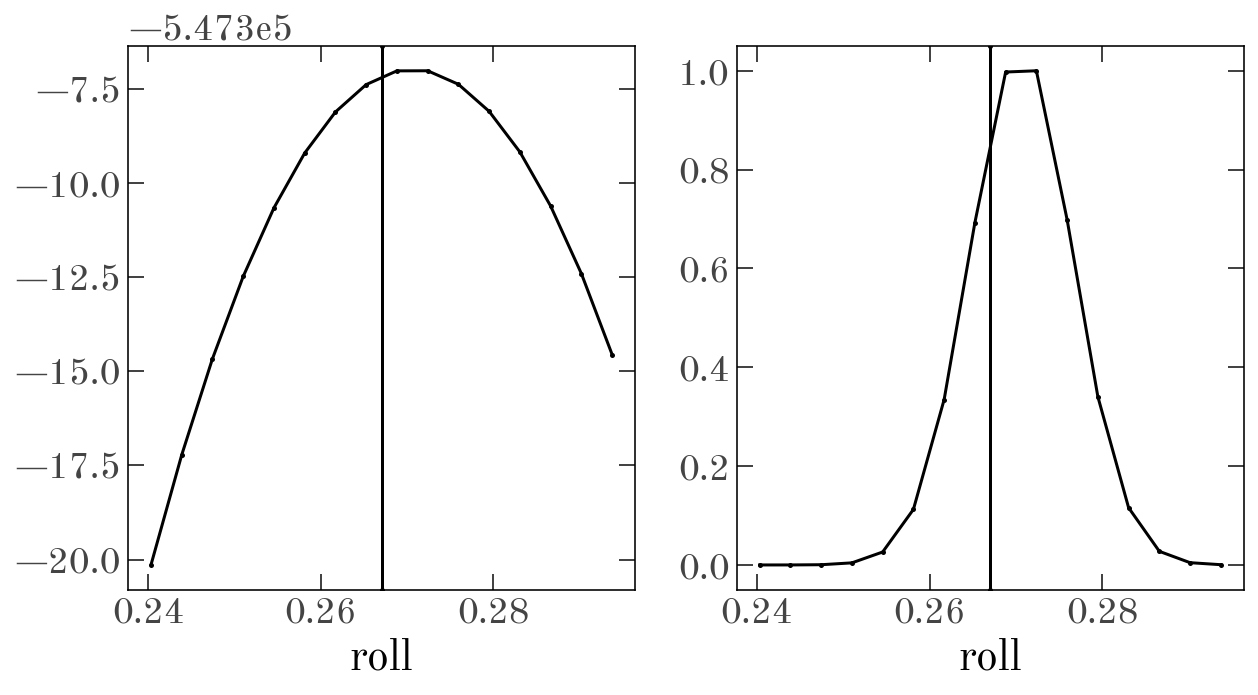

In [42]:
for i in range(all_lls.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(p0_names[i])
        ax.axvline(p0[i])

In [59]:
full_res = minimize(
    lambda *args: -ln_likelihood(*args), 
    x0=p0, 
    args=(data, truth['sgrA'], ln_density_args, min_b, max_dist), 
    method='nelder-mead'
)

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:51: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


In [60]:
np.array(p0)

array([ 11.51292546,   5.29831737,   6.68461173,   0.3       ,
       174.35      ,   0.26703538])

In [61]:
full_res.x

array([ 11.52103127,   5.30784134,   6.69455547,   0.30561021,
       185.38616088,   0.26951626])

In [62]:
rng = np.random.default_rng(seed=42)

bootstrap_res = []
for i in range(32):
    print(i, end='\r')
    batch = data[:, rng.choice(data.shape[1], size=data.shape[1])]
    res = minimize(lambda *args: -ln_likelihood(*args), 
                   x0=p0, args=(batch, truth['sgrA'], ln_density_args, min_b, max_dist), 
                   method='nelder-mead')
    bootstrap_res.append(res)

In [63]:
np.all([res.success for res in bootstrap_res])

True

In [64]:
bootstrap_optp = np.array([res.x for res in bootstrap_res])

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:51: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-1261382.5968822166

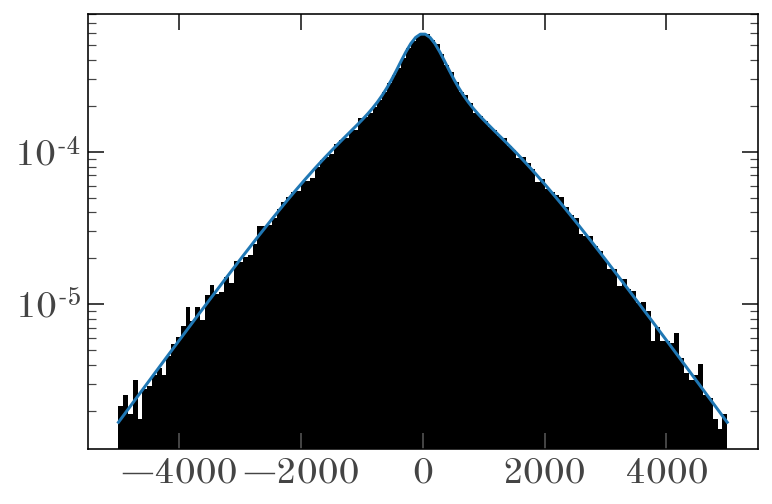

In [66]:
ln_likelihood(p0, sim_gal.xyz.decompose(usys).value, truth['sgrA'], 
              ln_density_args, min_b, max_dist,
              plot=True)

/Users/apricewhelan/projects/solar-velocity/solaroid/likelihood.py:51: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-1260117.5517481016

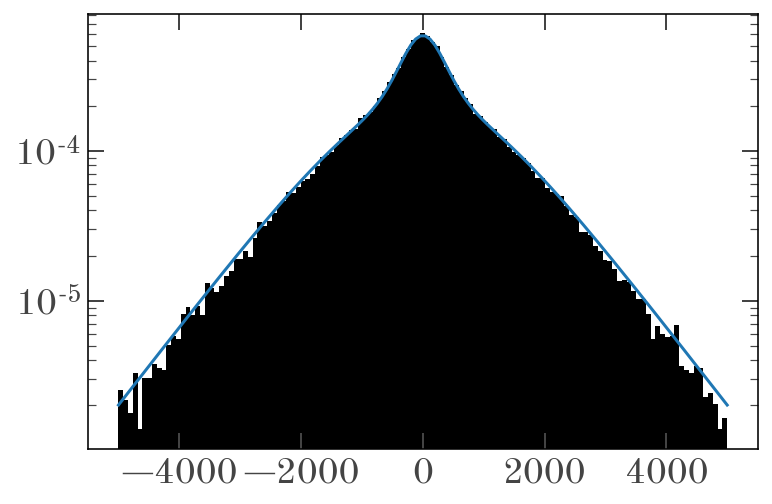

In [67]:
ln_likelihood(bootstrap_optp[0], sim_gal.xyz.decompose(usys).value, truth['sgrA'], 
              ln_density_args, min_b, max_dist,
              plot=True)

In [68]:
import corner

In [69]:
np.array(p0)

array([ 11.51292546,   5.29831737,   6.68461173,   0.3       ,
       174.35      ,   0.26703538])

In [70]:
np.mean(bootstrap_optp, axis=0)

array([ 11.52766994,   5.30675049,   6.71235059,   0.30708625,
       186.10816611,   0.26933476])

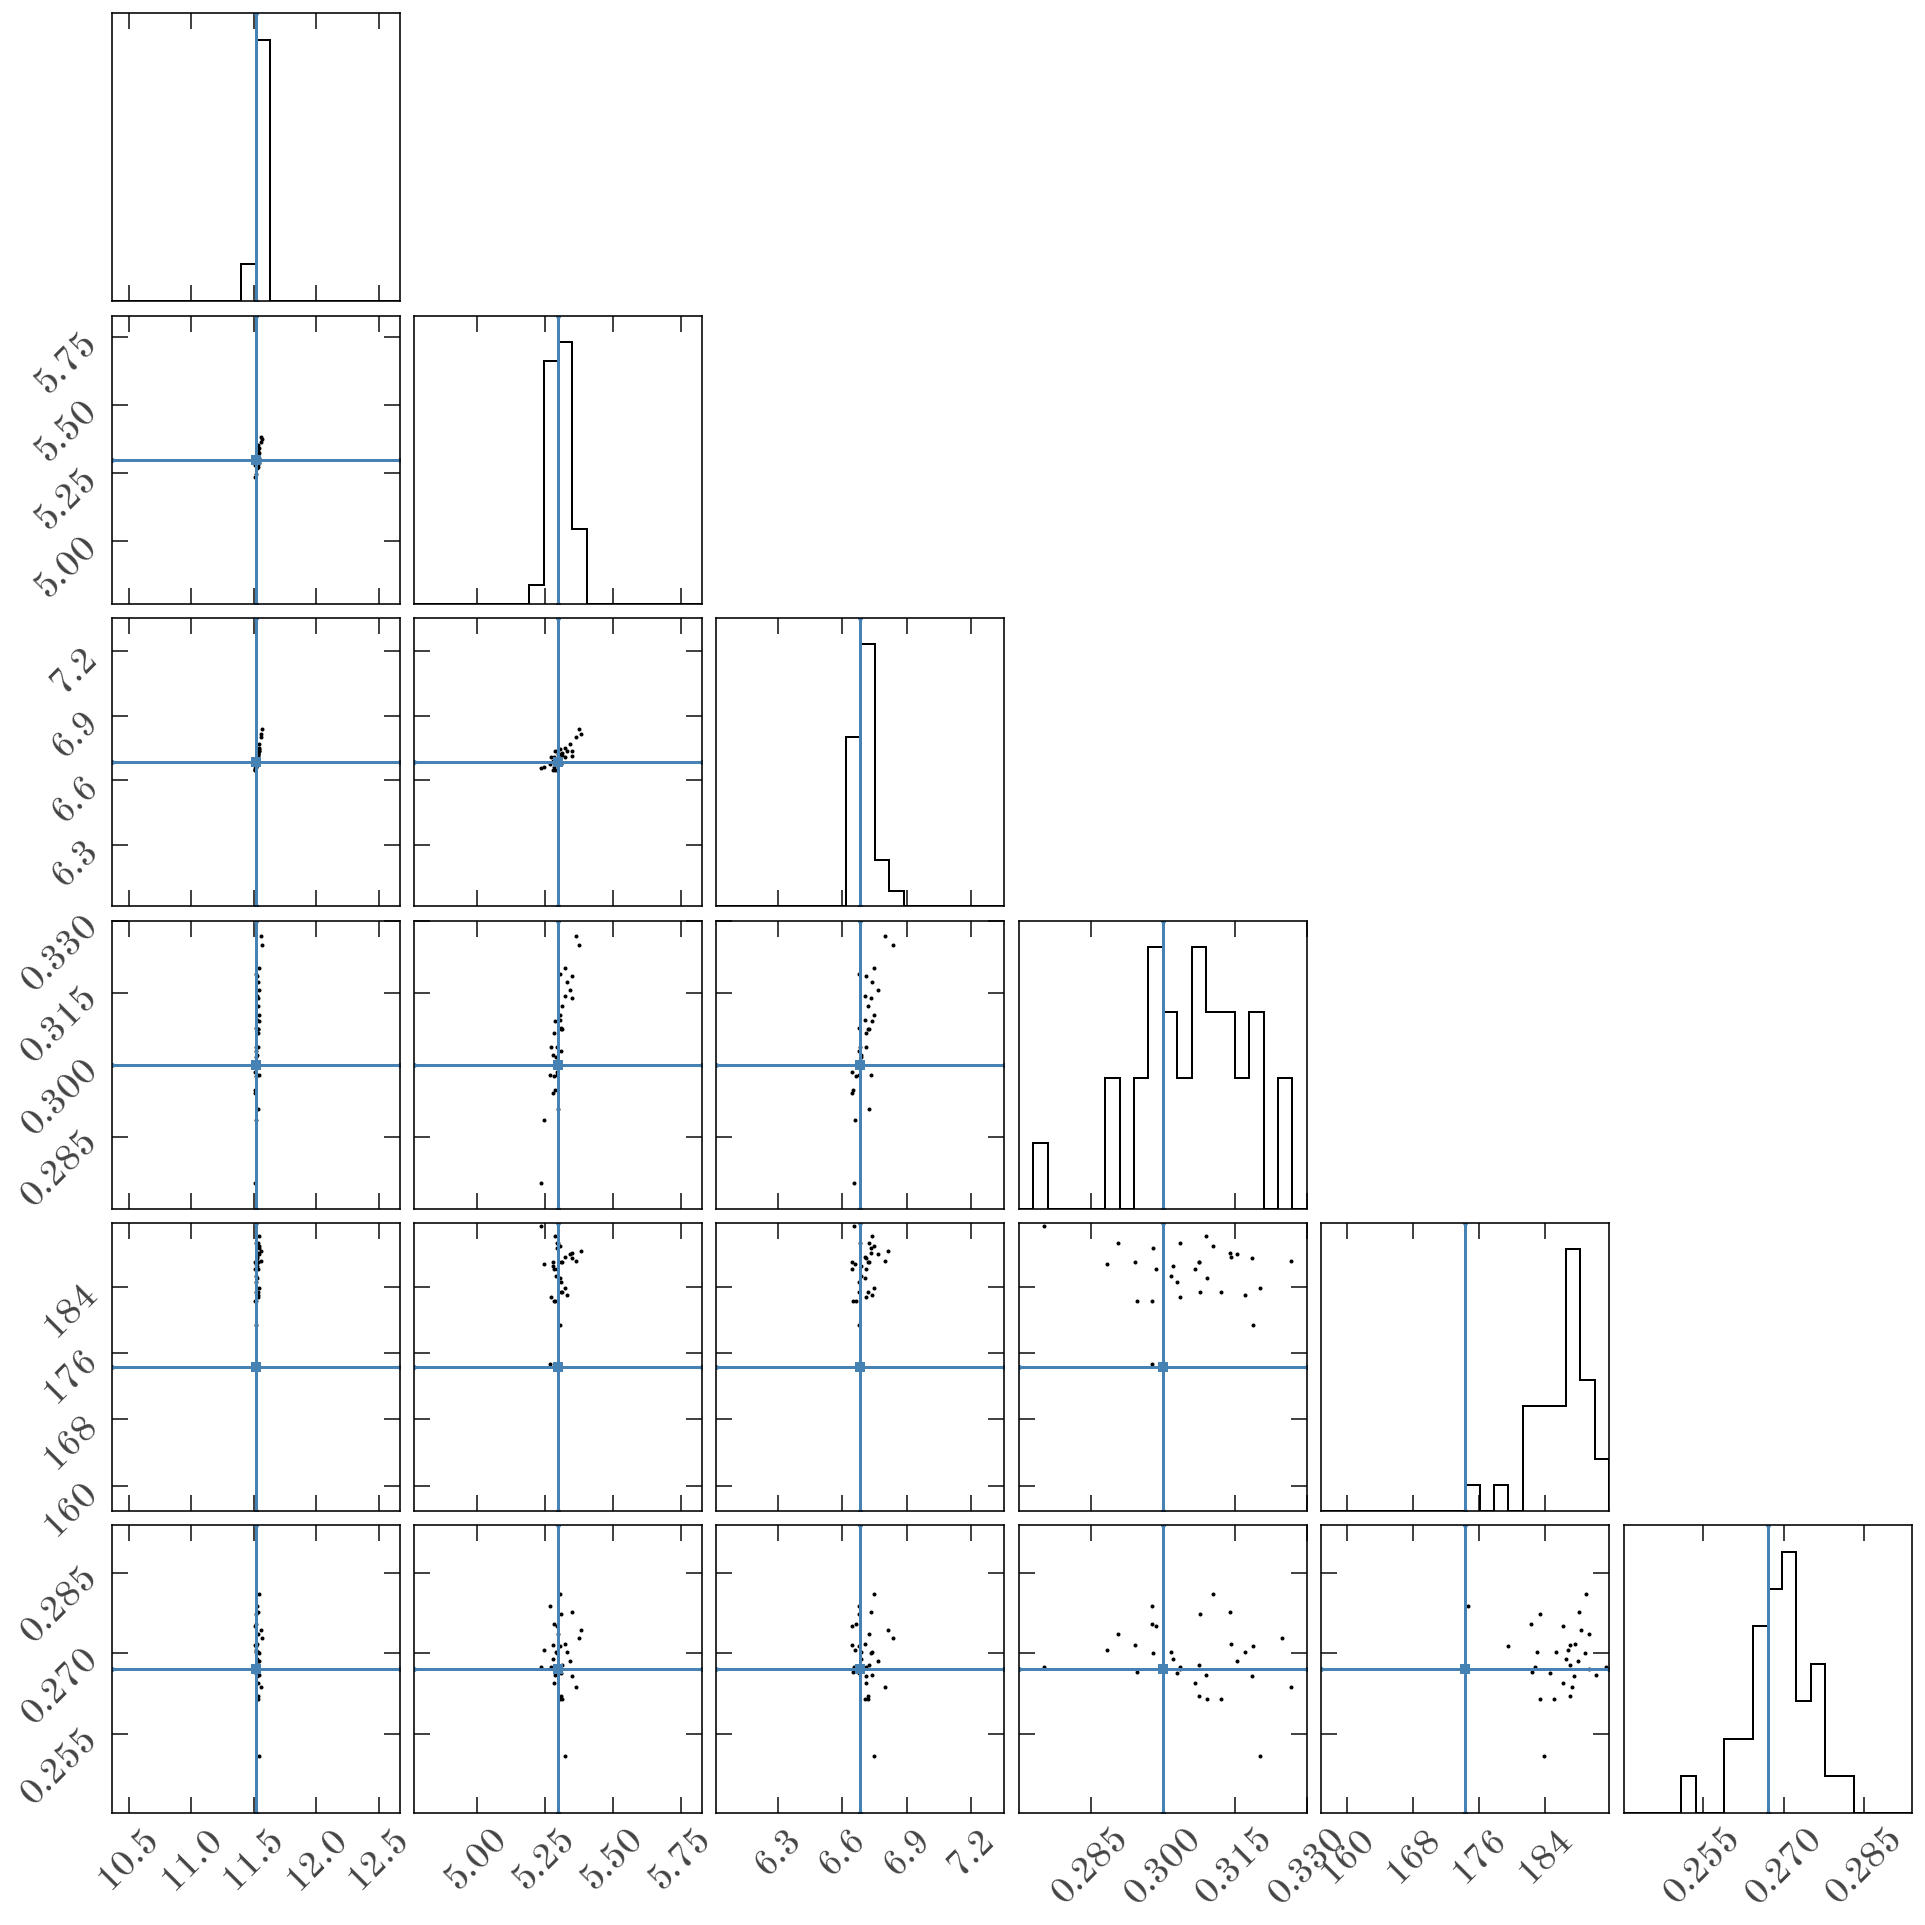

In [71]:
_ = corner.corner(bootstrap_optp, truths=p0, data_kwargs=dict(alpha=1),
                  range=np.array([0.9, 1.1])[None] * np.array(p0)[:, None],
                  plot_contours=False, plot_density=False)